In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.float_format', lambda x: '%.3f' % x)

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
def read_df(filename):
    df = pd.read_parquet(filename)
    df['duration'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']
    print(df.info())
    df['duration'] = df['duration'].apply(lambda x: x.total_seconds() / 60)
    df = df[(df['duration'] >= 1) & (df['duration'] <=60)].reset_index(drop=True)
    categorical = ['PULocationID' , 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    return df

In [3]:
df_train = pd.read_parquet('datasets/yellow_tripdata_2022-01.parquet', engine='pyarrow')
df_feb = pd.read_parquet('datasets/yellow_tripdata_2022-02.parquet')

In [4]:
df_train = read_df('datasets/yellow_tripdata_2022-01.parquet')
df_val = read_df('datasets/yellow_tripdata_2022-02.parquet')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2463931 entries, 0 to 2463930
Data columns (total 20 columns):
 #   Column                 Dtype          
---  ------                 -----          
 0   VendorID               int64          
 1   tpep_pickup_datetime   datetime64[ns] 
 2   tpep_dropoff_datetime  datetime64[ns] 
 3   passenger_count        float64        
 4   trip_distance          float64        
 5   RatecodeID             float64        
 6   store_and_fwd_flag     object         
 7   PULocationID           int64          
 8   DOLocationID           int64          
 9   payment_type           int64          
 10  fare_amount            float64        
 11  extra                  float64        
 12  mta_tax                float64        
 13  tip_amount             float64        
 14  tolls_amount           float64        
 15  improvement_surcharge  float64        
 16  total_amount           float64        
 17  congestion_surcharge   float64        
 18  ai

In [5]:
df_train.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.000,3.800,1.000,N,142,236,1,14.500,3.000,0.500,3.650,0.000,0.300,21.950,2.500,0.000,17.817
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.000,2.100,1.000,N,236,42,1,8.000,0.500,0.500,4.000,0.000,0.300,13.300,0.000,0.000,8.400
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.000,0.970,1.000,N,166,166,1,7.500,0.500,0.500,1.760,0.000,0.300,10.560,0.000,0.000,8.967
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.000,1.090,1.000,N,114,68,2,8.000,0.500,0.500,0.000,0.000,0.300,11.800,2.500,0.000,10.033
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.000,4.300,1.000,N,68,163,1,23.500,0.500,0.500,3.000,0.000,0.300,30.300,2.500,0.000,37.533


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2421440 entries, 0 to 2421439
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           object        
 8   DOLocationID           object        
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

In [7]:
df_train.describe()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration
count,2421440.000,2421440,2421440,2354481.000,2421440.000,2354481.000,2421440.000,2421440.000,2421440.000,2421440.000,2421440.000,2421440.000,2421440.000,2421440.000,2354481.000,2354481.000,2421440.000
mean,1.700,2022-01-17 01:35:16.982017792,2022-01-17 01:47:57.258748160,1.390,5.374,1.359,1.189,12.662,1.014,0.494,2.372,0.364,0.297,18.885,2.302,0.081,12.671
min,1.000,2008-12-31 23:03:01,2008-12-31 23:06:56,0.000,0.000,1.000,0.000,-335.000,-4.500,-0.500,-125.220,-31.400,-0.300,-253.300,-2.500,-1.250,1.000
25%,1.000,2022-01-09 15:35:25,2022-01-09 15:47:44,1.000,1.060,1.000,1.000,6.500,0.000,0.500,1.000,0.000,0.300,11.300,2.500,0.000,6.433
50%,2.000,2022-01-17 11:58:39.500000,2022-01-17 12:09:32.500000,1.000,1.760,1.000,1.000,9.000,0.500,0.500,2.000,0.000,0.300,14.630,2.500,0.000,10.233
75%,2.000,2022-01-24 13:30:43.500000,2022-01-24 13:43:12.500000,1.000,3.120,1.000,1.000,13.500,2.500,0.500,3.000,0.000,0.300,19.800,2.500,0.000,16.133
max,6.000,2022-05-18 20:41:57,2022-05-18 20:47:45,9.000,306159.280,99.000,5.000,401092.320,33.500,3.300,888.880,193.300,0.300,401095.620,2.500,1.250,60.000
std,0.471,NaN,NaN,0.984,552.446,5.586,0.488,257.990,1.234,0.071,2.697,1.637,0.039,258.126,0.710,0.308,8.999


In [8]:
df = df_train.copy()

In [9]:
df['duration'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']

In [10]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.000,3.800,1.000,N,142,236,1,14.500,3.000,0.500,3.650,0.000,0.300,21.950,2.500,0.000,0 days 00:17:49
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.000,2.100,1.000,N,236,42,1,8.000,0.500,0.500,4.000,0.000,0.300,13.300,0.000,0.000,0 days 00:08:24
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.000,0.970,1.000,N,166,166,1,7.500,0.500,0.500,1.760,0.000,0.300,10.560,0.000,0.000,0 days 00:08:58
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.000,1.090,1.000,N,114,68,2,8.000,0.500,0.500,0.000,0.000,0.300,11.800,2.500,0.000,0 days 00:10:02
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.000,4.300,1.000,N,68,163,1,23.500,0.500,0.500,3.000,0.000,0.300,30.300,2.500,0.000,0 days 00:37:32


In [11]:
df['duration'] = df['duration'].apply(lambda x: x.total_seconds() / 60)

In [12]:
df.duration.describe()

count   2421440.000
mean         12.671
std           8.999
min           1.000
25%           6.433
50%          10.233
75%          16.133
max          60.000
Name: duration, dtype: float64

In [13]:
df = df[(df['duration'] >= 1) & (df['duration'] <=60)].reset_index(drop=True)
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.000,3.800,1.000,N,142,236,1,14.500,3.000,0.500,3.650,0.000,0.300,21.950,2.500,0.000,17.817
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.000,2.100,1.000,N,236,42,1,8.000,0.500,0.500,4.000,0.000,0.300,13.300,0.000,0.000,8.400
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.000,0.970,1.000,N,166,166,1,7.500,0.500,0.500,1.760,0.000,0.300,10.560,0.000,0.000,8.967
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.000,1.090,1.000,N,114,68,2,8.000,0.500,0.500,0.000,0.000,0.300,11.800,2.500,0.000,10.033
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.000,4.300,1.000,N,68,163,1,23.500,0.500,0.500,3.000,0.000,0.300,30.300,2.500,0.000,37.533


In [14]:
df.duration.describe()

count   2421440.000
mean         12.671
std           8.999
min           1.000
25%           6.433
50%          10.233
75%          16.133
max          60.000
Name: duration, dtype: float64

In [15]:
(len(df) - len(df)) / len(df) *100

0.0

In [16]:
categorical = ['PULocationID' , 'DOLocationID']
df[categorical] = df[categorical].astype(str)

In [17]:
train_dicts = df[categorical].to_dict(orient='records')

In [18]:
dv = DictVectorizer()
x_train = dv.fit_transform(train_dicts)

In [19]:
x_train

<2421440x515 sparse matrix of type '<class 'numpy.float64'>'
	with 4842880 stored elements in Compressed Sparse Row format>

In [20]:
target = 'duration'
y_train = df['duration'].values

In [21]:
lr = LinearRegression()
lr.fit(x_train, y_train)

LinearRegression()

In [22]:
y_pred = lr.predict(x_train)

/var/folders/hs/0zv3m4r94rxc4xfktmvc3m300000gn/T/ipykernel_95391/1505421196.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/var/folders/hs/0zv3m4r94rxc4xfktmvc3m300000gn/T/ipykernel_95391/1505421196.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, lab

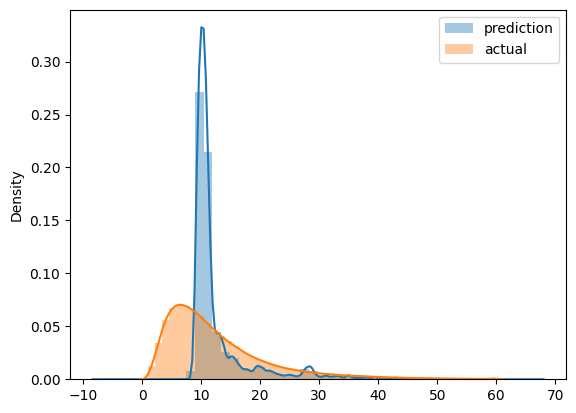

In [23]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')
plt.legend()

In [24]:
mean_squared_error(y_train, y_pred, squared=False)

6.986190814952337

### for Validation set

In [25]:
val_dicts = df_val[categorical].to_dict(orient='records')
x_val = dv.transform(val_dicts)

target = ['duration']
y_val = df_val[target].values

y_pred = lr.predict(x_val)

In [26]:
mean_squared_error(y_val, y_pred, squared=False)

7.786407163179794